### CAPSTONE PROJECT - Computer Vision: PNEUMONIA DETECTION CHALLENGE

**PROBLEM STATEMENT**

• **DOMAIN**: Health Care

• **CONTEXT**: Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of the lungs. In this challenge, you’re required to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

• **DATA DESCRIPTION**:
- In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was
determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the
appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.
- Dataset has been attached along with this project. Please use the same for this capstone project.
- Original link to the dataset : https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data [ for your reference
only ]. You can refer to the details of the dataset in the above link
- Acknowledgements: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements.

• **PROJECT OBJECTIVE**: Design a DL based algorithm for detecting pneumonia.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
import seaborn as sns

#!pip install pydicom
import pydicom as dcm

from glob import glob

import cv2

from pathlib import Path

from tqdm import tqdm_notebook

import warnings; 
warnings.filterwarnings('ignore')

# SET RANDOM SEED
np.random.seed(2022)

#### Import the data.

In [2]:
#csv files
class_info = pd.read_csv('D:/Nikhila/PGP - AIML/2. Projects/10. Capstone Project/CV Capstone/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('D:/Nikhila/PGP - AIML/2. Projects/10. Capstone Project/CV Capstone/stage_2_train_labels.csv')

#path
PATH = 'D:/Nikhila/PGP - AIML/2. Projects/10. Capstone Project/CV Capstone/'
os.chdir(PATH)

TRAIN_IMAGES = os.path.join(PATH + 'stage_2_train_images/')
TEST_IMAGES = os.path.join(PATH + 'stage_2_test_images/')

#Output files will be stored here
OUTPUT_DIR = os.path.join(PATH + 'output/')

#### Exploratory Data Analysis

#####  1.Shape of the dataset

In [3]:
print(f'Shape of the Train Labels dataframe: {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')
print(f'Shape of the Class info dataframe: {class_info.shape[0]} rows and {class_info.shape[1]} columns')

Shape of the Train Labels dataframe: 30227 rows and 6 columns
Shape of the Class info dataframe: 30227 rows and 2 columns


##### 2.Duplicate number of records in the dataset

In [4]:
print('Number of duplicates in Train Labels dataframe: {}'.format(len(train_labels) - (train_labels['patientId'].nunique())))
print('Number of duplicates in Class info dataframe: {}'.format(len(class_info) - (class_info['patientId'].nunique())))

Number of duplicates in Train Labels dataframe: 3543
Number of duplicates in Class info dataframe: 3543


##### 3.Unique number of records in the dataset

In [5]:
print('Number of unique records in Train Labels dataframe: {}'.format(train_labels['patientId'].nunique()))
print('Number of unique records in Class info dataframe: {}'.format(class_info['patientId'].nunique()))

Number of unique records in Train Labels dataframe: 26684
Number of unique records in Class info dataframe: 26684


##### 4.Head of the dataset

In [6]:
print('Train labels dataframe:\n'); display(train_labels.head())
print('\nClass info dataframe:\n'); display(class_info.head())

Train labels dataframe:



,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1



Class info dataframe:



,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


**Observation:** We have NaN present in the bounding boxes in train label dataframe.

##### 5.Numbers of nulls in bounding boxes

In [7]:
print('Nulls in bounding boxes: {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict())) 
print('Null value counts for the targets: {}'.format(train_labels['Target'].value_counts().to_dict()))

Nulls in bounding boxes: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Null value counts for the targets: {0: 20672, 1: 9555}


**Observation:** Train labels with target as 0 (negative) does not have bounding boxes.

##### 6.Distribution of 'Target' and 'class' column

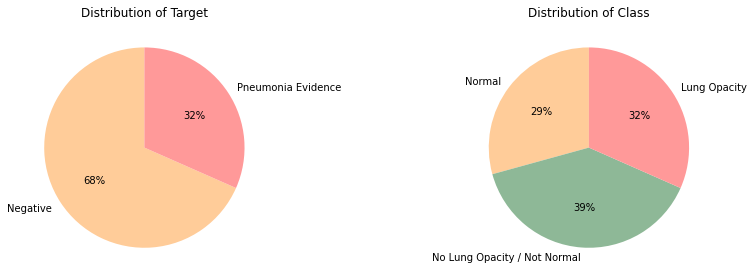

In [8]:
fig = plt.figure(figsize = (12, 4))

ax = fig.add_subplot(121)
g = (train_labels['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['#ffcc99', '#ff9999'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 10)
    .set_ylabel(''))

ax = fig.add_subplot(122)
g = (class_info['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['#ffcc99', '#8EB897', '#ff9999'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 10)
    .set_ylabel(''))

plt.tight_layout()

**Observation** 
- Imbalanced dataset.
- In class info dataframe, ***Normal & No lung Opacity/Not Normal*** can be considered as ***Negative*** which constitues to 68%.

#### 7.Number of patientID's per bounding boxes in the dataset

In [9]:
bboxes = train_labels.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
train_labels = train_labels.merge(bboxes, on = 'patientId', how = 'left')

(bboxes.groupby('number_of_boxes').size().to_frame('number_of_patientIDs_per_boxes').reset_index()
.set_index('number_of_boxes')
.sort_values(by = 'number_of_boxes'))

,number_of_patientIDs_per_boxes
number_of_boxes,
1,23286
2,3266
3,119
4,13


**Observation:** 
- 23286 patientIds have 1 bounding boxes.
- While 3266, 119 & 13 patients have 2, 3 & 4 bounding boxes respectively.

In [10]:
#Example
train_labels[train_labels.patientId=='c1f7889a-9ea9-4acb-b64c-b737c929599a']

,patientId,x,y,width,height,Target,number_of_boxes
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,2
30226,c1f7889a-9ea9-4acb-b64c-b737c929599a,233.0,424.0,201.0,356.0,1,2


In [11]:
class_info[class_info.patientId=='c1f7889a-9ea9-4acb-b64c-b737c929599a']

,patientId,class
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity
30226,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


#### 8.Number of class associated with each patientID

In [12]:
print('Each patientId is associated with only {} class'.format(class_info.groupby(['patientId'])['class'].nunique().max()))

Each patientId is associated with only 1 class


#### Merge train_labels, class_info & train_images dataframe

In [13]:
train_class = pd.concat([train_labels, class_info['class']], axis = 1)

print('Shape of the dataframe after the merge: {}'.format(train_class.shape))
print('Shape of the dataframe with unique records after the merge: {}'.format(train_class['patientId'].nunique()))

Shape of the dataframe after the merge: (30227, 8)
Shape of the dataframe with unique records after the merge: 26684


In [14]:
images = pd.DataFrame({'path': glob(os.path.join(TRAIN_IMAGES, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])

print('Number of images in the training folder: {}'.format(images.shape[0]))
print('Columns in the training images dataframe: {}'.format(list(images.columns)))

assert images.shape[0] == len(list(set(train_class['patientId']))), 'Number of training images should be equal to the unique patientIds we have'

Number of images in the training folder: 26684
Columns in the training images dataframe: ['path', 'patientId']


In [15]:
train_class = train_class.merge(images, on = 'patientId', how = 'left')
print('Shape of the train_class dataframe after merge: {}'.format(train_class.shape))
del images

Shape of the train_class dataframe after merge: (30227, 9)


#### Map training and testing images to its classes and its annotations.

Images are stored in DICOM (.dcm) format which is an international standard to transmit, store, retrieve, print, process, and display medical imaging information. Digital Imaging and Communications in Medicine (DICOM) makes medical imaging information interoperable. We will make use of pydicom package here to read the images.

In [16]:
sample_patient_id = train_labels['patientId'][0]
dcm_file = TRAIN_IMAGES + '{}.dcm'.format(sample_patient_id)
dcm_data = dcm.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

**Observation** - 
- The dicom file contains some of the information that can be used for further analysis such as Patient's Sex, Patient's Age, body part examined, view position and modality. 
- Size of this image is rows & columns(1024 x 1024).

#### Feature extraction from the image files

In [17]:
# Helper function to get additional features from dicom images
def get_tags(data, path):
    images = os.listdir(path)
    for _, name in tqdm_notebook(enumerate(images)):
        img_path = os.path.join(path, name)
        img_data = dcm.read_file(img_path)
        idx = (data['patientId'] == img_data.PatientID)
        data.loc[idx,'PatientSex'] = img_data.PatientSex
        data.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        data.loc[idx,'BodyPartExamined'] = img_data.BodyPartExamined
        data.loc[idx,'ViewPosition'] = img_data.ViewPosition
        data.loc[idx,'Modality'] = img_data.Modality

In [18]:
print('Adding features such as {} from training images'.format(('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality')))
get_tags(train_class, TRAIN_IMAGES)

Adding features such as ('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality') from training images


0it [00:00, ?it/s]

In [19]:
#Saving for further analysis
train_class.to_pickle('./output/train_feature_engineered.pkl')

#reading the saved file
train_class = pd.read_pickle('./output/train_feature_engineered.pkl')
train_class.shape

(30227, 14)

In [20]:
train_class.head()

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,BodyPartExamined,ViewPosition,Modality
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...,F,51.0,CHEST,PA,CR
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...,F,48.0,CHEST,PA,CR
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...,M,19.0,CHEST,AP,CR
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...,M,28.0,CHEST,PA,CR
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...,F,32.0,CHEST,AP,CR


##### 1.Unique values present in 'BodyPartExamined' column

In [21]:
print('Unique value in BodyPartExamined column is: {}'.format(train_class['BodyPartExamined'].unique()[0]))

Unique value in BodyPartExamined column is: CHEST


##### 2.Unique values present in 'Modality' column

In [22]:
print('Unique value in Modality column is: {}'.format(train_class['Modality'].unique()[0]))

Unique value in Modality column is: CR


##### 3. Understand about 'PatientAge' column

###### a) Checking outliers

Minimum PatientAge in the training dataset: 1.0
Maximum PatientAge in the training dataset: 155.0



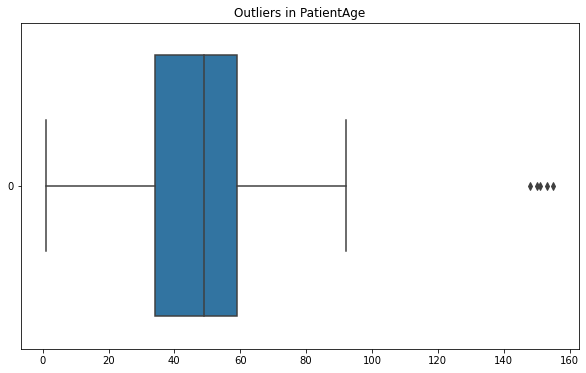

In [23]:
print('Minimum PatientAge in the training dataset: {}'.format(train_class['PatientAge'].min()))
print('Maximum PatientAge in the training dataset: {}'.format(train_class['PatientAge'].max()))

print()
fig = plt.figure(figsize = (10, 6))
ax = sns.boxplot(data = train_class['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

**Observation** - We can trim value to a specified lower and upper threshold. So an upper threshold of 100 in PatientAge would mean those outlier values being converted to 100.

In [24]:
train_class['PatientAge'] = train_class['PatientAge'].clip(train_class['PatientAge'].min(), 100)
train_class['PatientAge'].describe().astype(int)

count    30227
mean        46
std         16
min          1
25%         34
50%         49
75%         59
max        100
Name: PatientAge, dtype: int32

##### b) Distribution of  'PatientAge' column

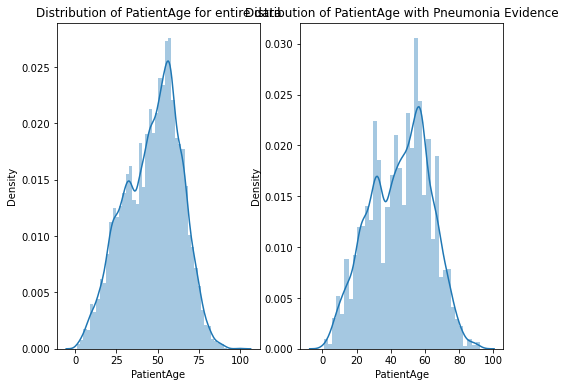

In [25]:
fig = plt.figure(figsize = (8, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(train_class['PatientAge'])
    .set_title('Distribution of PatientAge for entire data'))

ax = fig.add_subplot(122)
g = (sns.distplot(train_class.loc[train_class['Target'] == 1, 'PatientAge'])
    .set_title('Distribution of PatientAge with Pneumonia Evidence'))

 **Observation** - Distribution peaks for age group 40-70 both overall and with Pneumonia Evidence.

##### c) Creating bins for 'PatientAge' column to understand the distribution

In [26]:
train_class['AgeBins'] = pd.cut(train_class['PatientAge'], bins = 4, precision = 0, labels = ['0-25', '26-50', '51-75', '76-100'])

display(pd.concat([train_class['AgeBins'].value_counts().sort_index().rename('Counts of Age Bins for entire data'), 
                   train_class.loc[train_class['Target'] == 1, 'AgeBins'].value_counts().sort_index().rename('Counts of Age Bins with Pneumonia Evidence')], axis = 1))

,Counts of Age Bins for entire data,Counts of Age Bins with Pneumonia Evidence
0-25,3972,1478
26-50,12157,3917
51-75,13318,3895
76-100,780,265


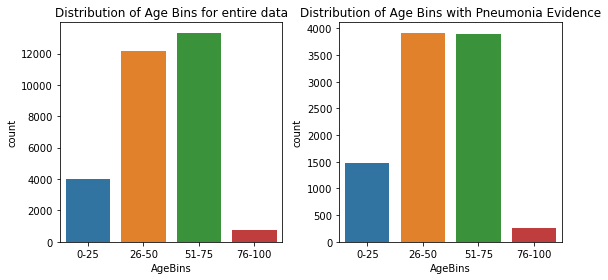

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
g = sns.countplot(x = train_class['AgeBins'], ax = ax1).set_title('Distribution of Age Bins for entire data')
g = sns.countplot(x = train_class.loc[train_class['Target'] == 1, 'AgeBins'], ax = ax2).set_title('Distribution of Age Bins with Pneumonia Evidence')
plt.tight_layout()

##### d)  Display images with bounding box for 'AgeBins' column

In [28]:
def bboxes_scatter(df1, df2, text1, text2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 8))
    fig.subplots_adjust(top = 0.85)
    fig.suptitle('Plotting centers of lung opacity\n{} & {}'.format(text1, text2))
    df1.plot.scatter(x = 'xw', y = 'yh', ax = ax1, alpha = 0.8, marker = '.', 
                   xlim = (0, 1024), ylim = (0, 1024), color = 'green')
    ax1.set_title('Centers of Lung Opacity\n{}'.format(text1))
    for i, row in df1.iterrows():
        ax1.add_patch(Rectangle(xy = (row['x'], row['y']),
                            width = row['width'], height = row['height'], 
                            alpha = 3.5e-3, color = 'yellow'))
    plt.title('Centers of Lung Opacity\n{}'.format(text2))
    df2.plot.scatter(x = 'xw', y = 'yh', ax = ax2, alpha = 0.8, marker = '.',
                   color = 'brown',  xlim = (0, 1024), ylim = (0, 1024))
    ax2.set_title('Centers of Lung Opacity\n{}'.format(text2))
    for i, row in df2.iterrows():
        ax2.add_patch(Rectangle(xy = (row['x'], row['y']),
                             width = row['width'], height = row['height'],
                             alpha = 3.5e-3, 
                             color = 'yellow'))
    plt.show()

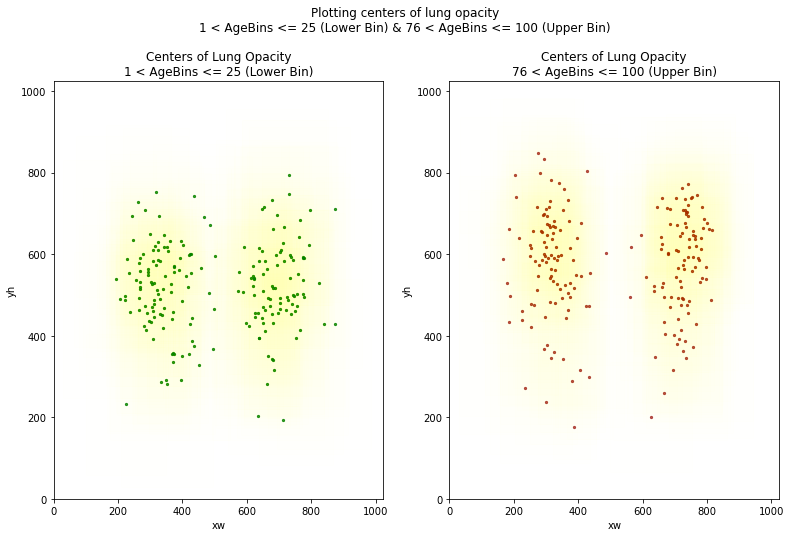

In [29]:
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class[train_class['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

df1 = bboxes[bboxes['AgeBins'] == '0-25'].sample(200)
df2 = bboxes[bboxes['AgeBins'] == '76-100'].sample(200)
bboxes_scatter(df1, df2, '1 < AgeBins <= 25 (Lower Bin)', '76 < AgeBins <= 100 (Upper Bin)')

##### 4.Combining 'PatientAge' & 'PatientGender' column

In [30]:
display(pd.concat([train_class['PatientSex'].value_counts(normalize = True).round(2).sort_values().rename('% Gender for entire data'), 
                   train_class.loc[(train_class['Target'] == 1), 'PatientSex']
                   .value_counts(normalize = True).round(2).sort_index().rename('% Gender with Pneumonia Evidence')], axis = 1))

,% Gender for entire data,% Gender with Pneumonia Evidence
F,0.43,0.42
M,0.57,0.58


#####  Display images with bounding box.

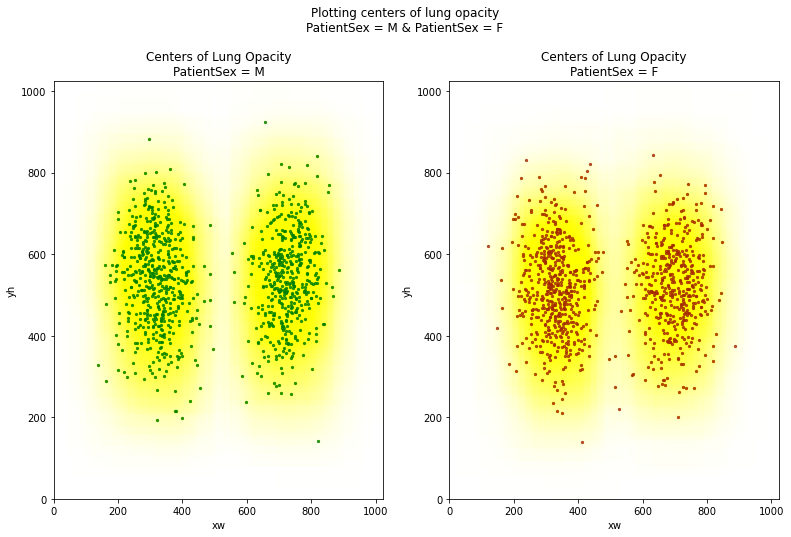

In [31]:
df1 = bboxes[bboxes['PatientSex'] == 'M'].sample(1000)
df2 = bboxes[bboxes['PatientSex'] == 'F'].sample(1000)
bboxes_scatter(df1, df2, 'PatientSex = M', 'PatientSex = F')

In [32]:
#Dropping the other features from train_class dataframe and save that as a pickle file
train_class.drop(['BodyPartExamined', 'Modality', 'AgeBins'], inplace = True, axis = 1)
train_class.to_pickle('./output/train_class_features.pkl')
train_class.shape

(30227, 12)

##### 5. Distributions of 'ViewPosition' column

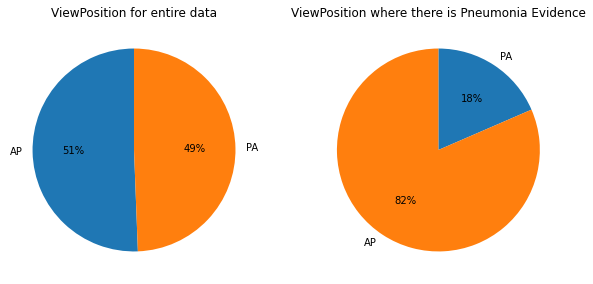

In [33]:
fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(121)
g = (train_class['ViewPosition'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%',  
          startangle = 90,
          title = 'ViewPosition for entire data', 
          fontsize = 10)
    .set_ylabel(''))

ax = fig.add_subplot(122)
g = (train_class.loc[train_class['Target'] == 1, 'ViewPosition']
     .value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          startangle = 90, counterclock = False, 
          title = 'ViewPosition where there is Pneumonia Evidence', 
          fontsize = 10)
    .set_ylabel(''))

**Observation** - Overall ViewPosition is almost equally distributed but when Target=1, most of the view position are AP.

#####  Display images with bounding box.

In [34]:
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class[train_class['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

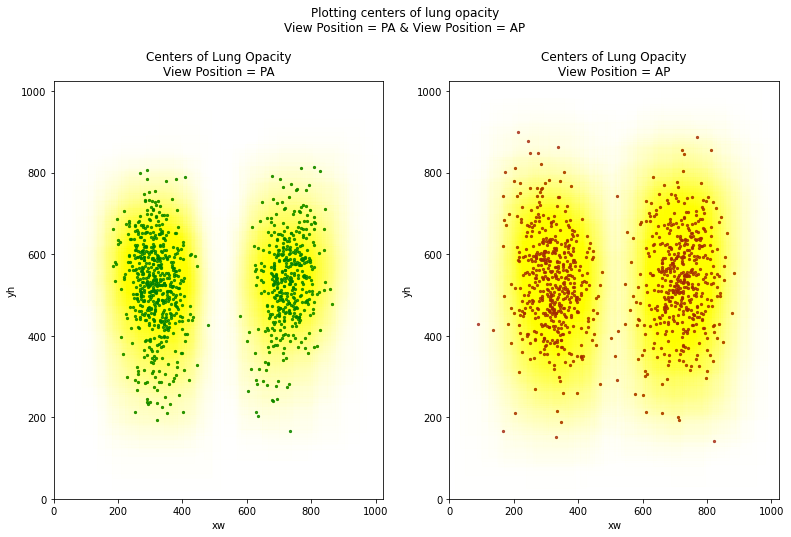

In [35]:
df1 = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
df2 = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)
bboxes_scatter(df1, df2, 'View Position = PA', 'View Position = AP')

#### Plotting DICOM Images

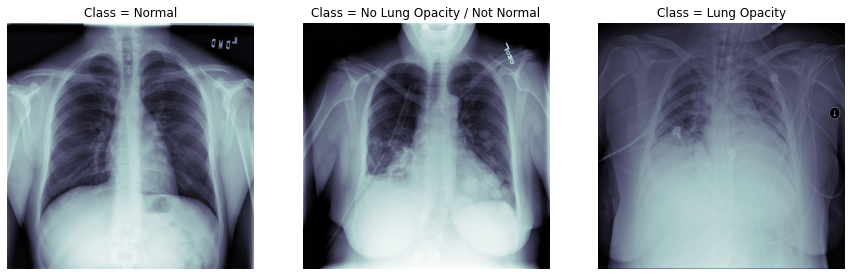

In [36]:
sample1 = train_class.loc[train_class['class'] == 'Normal'].iloc[0]
sample2 = train_class.loc[train_class['class'] == 'No Lung Opacity / Not Normal'].iloc[0]
sample3 = train_class.loc[train_class['class'] == 'Lung Opacity'].iloc[1]

ds1 = dcm.dcmread(sample1['path'])
ds2 = dcm.dcmread(sample2['path'])
ds3 = dcm.dcmread(sample3['path'])

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))

ax1.imshow(ds1.pixel_array, cmap = plt.cm.bone)
ax1.set_title('Class = Normal')
ax1.axis('off')

ax2.imshow(ds2.pixel_array, cmap = plt.cm.bone)
ax2.set_title('Class = No Lung Opacity / Not Normal')
ax2.axis('off')

ax3.imshow(ds3.pixel_array, cmap = plt.cm.bone)
ax3.set_title('Class = Lung Opacity')
ax3.axis('off')

plt.show()

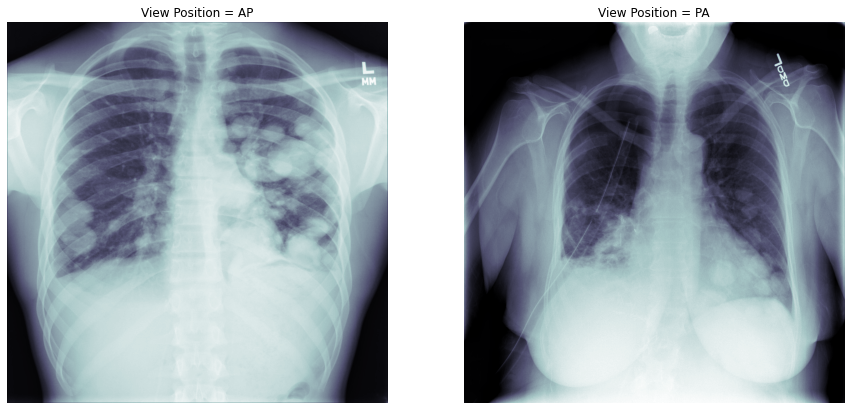

In [37]:
sample4 = train_class.loc[(train_class['ViewPosition'] == 'AP')].iloc[0]
sample5 = train_class.loc[(train_class['ViewPosition'] == 'PA')].iloc[0]

ds4 = dcm.dcmread(sample4['path'])
ds5 = dcm.dcmread(sample5['path'])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))

ax1.imshow(ds4.pixel_array, cmap = plt.cm.bone)
ax1.set_title('View Position = AP')
ax1.axis('off')

ax2.imshow(ds5.pixel_array, cmap = plt.cm.bone)
ax2.set_title('View Position = PA')
ax2.axis('off')

plt.show()

In [38]:
def plot_dicom_images(data, df, img_path):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3, 3, figsize = (16, 18))
    for i, row in enumerate(img_data):
        image = row['patientId'] + '.dcm'
        path = os.path.join(img_path, image)
        data = dcm.read_file(path)
        rows = df[df['patientId'] == row['patientId']]
        age = rows.PatientAge.unique().tolist()[0]
        sex = data.PatientSex
        part = data.BodyPartExamined
        vp = data.ViewPosition
        modality = data.Modality
        data_img = dcm.dcmread(path)
        ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                              .format(row['patientId'], age, sex, part, 
                                      vp, modality, row['Target'], 
                                      row['class'], row['x'], 
                                      row['y'], row['width'],
                                      row['height']))
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                      width = row['width'], height = row['height'], 
                      color = 'blue', alpha = 0.15)) 
    plt.show()

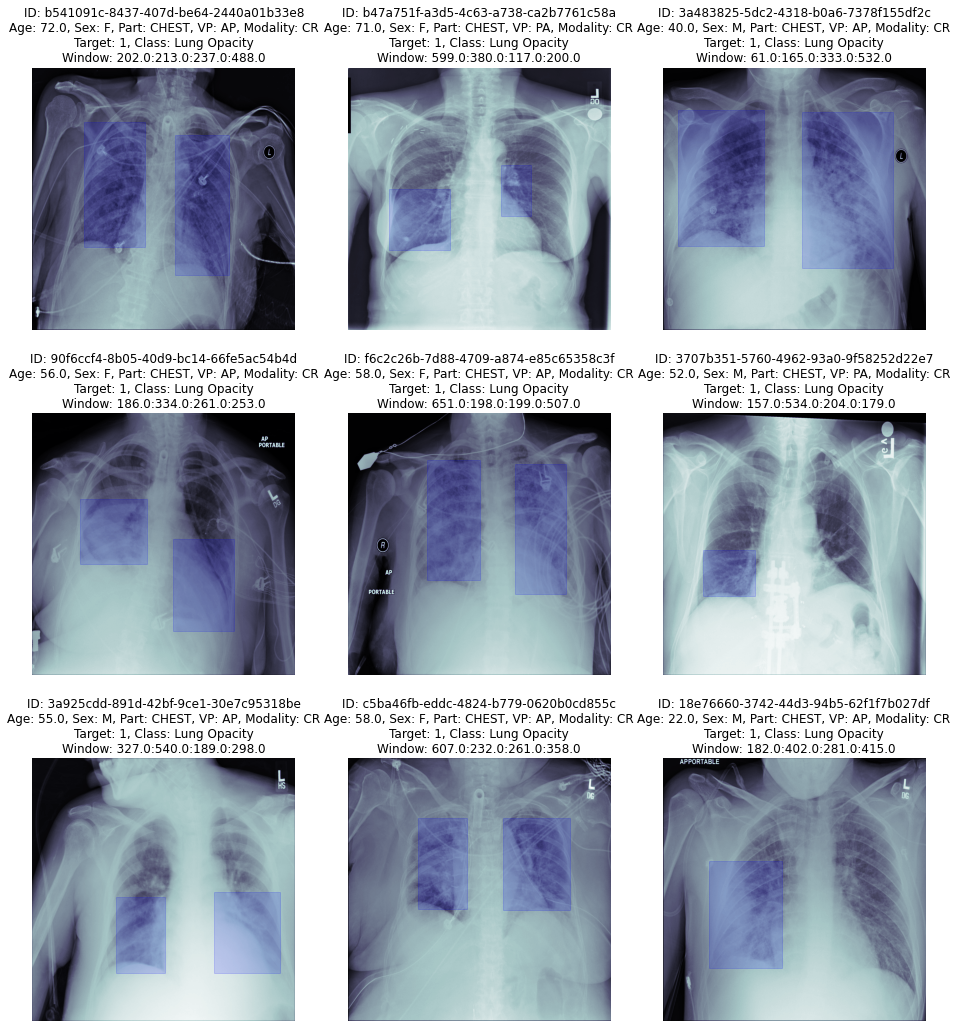

In [39]:
plot_dicom_images(data = train_class.loc[(train_class['Target'] == 1)].sample(9), 
                  df = train_class, img_path = TRAIN_IMAGES)

##### **Read 'train_class_features.pkl' file which was saved**

In [3]:
train_class = pd.read_pickle(OUTPUT_DIR + 'train_class_features.pkl')
display(train_class.shape, train_class.head())

(30227, 12)

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...,M,19.0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...,M,28.0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...,F,32.0,AP


In [4]:
#copy for further analysis
path_class_target = train_class[['patientId', 'path', 'class', 'Target']].copy(deep = True)

#converting .dcm to .png format
path_class_target['path'] = (path_class_target['path']
                             .str.replace('stage_2_train_images', 'stage_2_train_images_png')
                             .str.replace('.dcm', '.png'))

#droping duplicates
path_class_target.drop_duplicates(inplace = True)

In [5]:
print(f'Shape of the new dataframe: {path_class_target.shape[0]} rows and {path_class_target.shape[1]} columns')
display(path_class_target.nunique())

print('--'*40)

print('\nDistribution of target')
display(path_class_target['Target'].value_counts())

print('--'*40)

print('\nDistribution of class')
display(path_class_target['class'].value_counts())

Shape of the new dataframe: 26684 rows and 4 columns


patientId    26684
path         26684
class            3
Target           2
dtype: int64

--------------------------------------------------------------------------------

Distribution of target


0    20672
1     6012
Name: Target, dtype: int64

--------------------------------------------------------------------------------

Distribution of class


No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

#### Split the data in train, valid and test sets